In [1]:
# data Management/investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# for pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# for splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# for evaluating our model's performance
import sklearn.metrics as m

# pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
# load and evaluate data basics
train = pd.read_csv("../train_data.csv")
test = pd.read_csv("../test_data.csv")

In [3]:
# find the shape of the training data
train.shape

(43590, 39)

<AxesSubplot:>

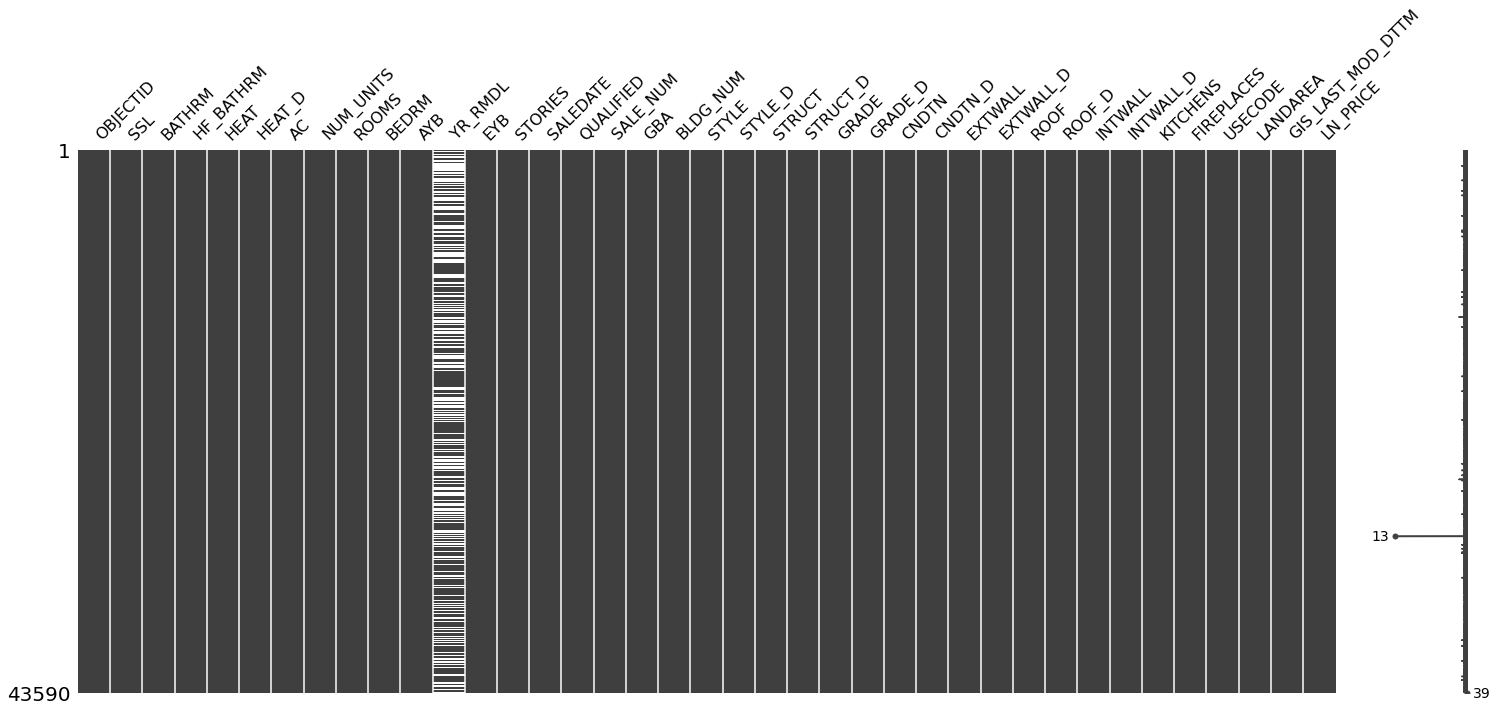

In [4]:
# look for missing training data
miss.matrix(train)

Identify our relevent independent variables and 'clean' the data.

In [5]:
# define list of predictors to predict the outcome
variables = ['BATHRM','HF_BATHRM', 'ROOMS', 'BEDRM', 'KITCHENS', 'CNDTN', 'GRADE', 'FIREPLACES']

In [6]:
# we preform the process on the test and the training data at the same time.

# remove missing values from our independent variables
train = train.dropna(subset = variables)
test = test.dropna(subset = variables)

# Drop observations where the outcome is missing
train = train[~train.LN_PRICE.isna()]
test = test[~test.LN_PRICE.isna()]

# Only consider houses that actually sold (i.e. sale price > 0)
train = train[train.LN_PRICE > 0]
test = test[test.LN_PRICE > 0]

In [7]:
# adjust some of the independent variables

# # take the log of the independent variables
# train['LANDAREA'] = np.log(train['LANDAREA']).round(2)
# test['LANDAREA'] = np.log(test['LANDAREA']).round(2)

# # combine the half and full bathroom values
# train['HF_BATHRM'] = train['HF_BATHRM'] * 0.5
# train['BATHRM'] = train['BATHRM'] + train['HF_BATHRM']
# train = train.drop('HF_BATHRM', 1)

# test['HF_BATHRM'] = test['HF_BATHRM'] * 0.5
# test['BATHRM'] = test['BATHRM'] + test['HF_BATHRM']
# test = test.drop('HF_BATHRM', 1)


In [8]:
# # redefine list of predictors to predict the outcome
# variables = ['BATHRM', 'ROOMS', 'BEDRM', 'KITCHENS', 'CNDTN', 'GRADE', 'FIREPLACES', 'LANDAREA']

In [9]:
# split our data sets into predictors and outcome
outcome_train = train.LN_PRICE
predictors_train = train[variables]

outcome_test = test.LN_PRICE
predictors_test = test[variables]

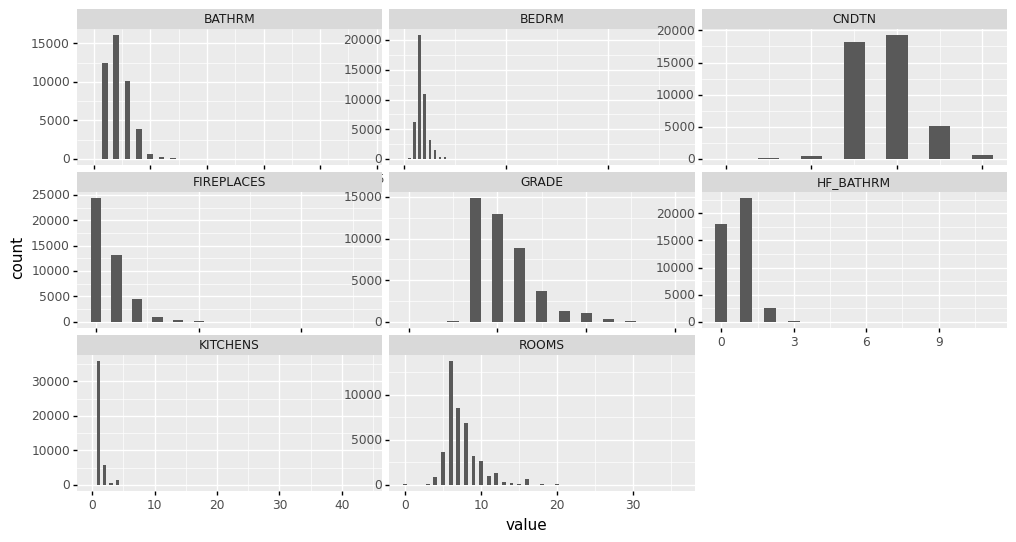

<ggplot: (97714565509)>

In [10]:
# find the distributions of independent variables
(
    ggplot(predictors_train.melt(), aes(x = "value")) +
    geom_histogram(binwidth = 0.5) +
    facet_wrap("variable", scales = "free") +
    theme(figure_size = (12, 6))
)

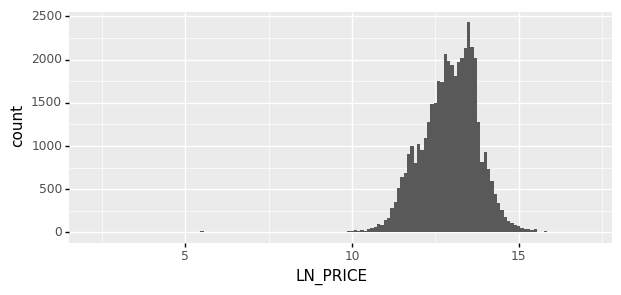

<ggplot: (97714789813)>

In [11]:
# look into the outcome variable
(
    ggplot(pd.DataFrame(dict(LN_PRICE = outcome_train)), aes(x = "LN_PRICE")) +
    geom_histogram(binwidth = 0.1) +
    theme(figure_size = (7, 3)) 
)

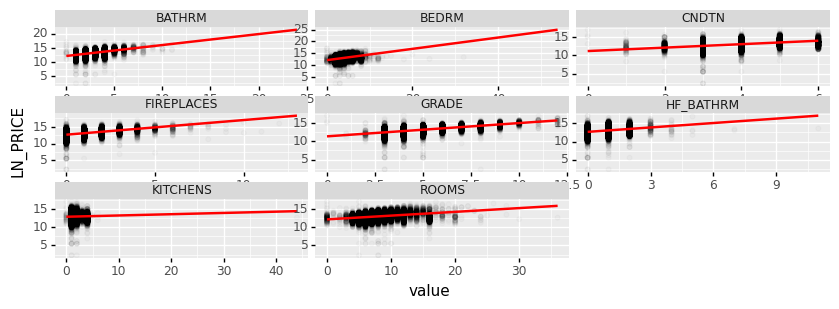

<ggplot: (97714767565)>

In [12]:
# check the predictors relate to the outcome LN_PRICE

# create a copy of the predictor_training data
X_ = predictors_train.copy()

# use the outcome_train and add it to the dataset
X_["LN_PRICE"] = outcome_train

# plot the predictors against the outcome
(
    ggplot(X_.melt(id_vars = ["LN_PRICE"]), aes(x = "value", y = "LN_PRICE")) +
    geom_point(alpha = .02) +
    facet_wrap("variable", scales = "free") +
    geom_smooth(method = "lm", se = False, color = "red") +
    theme(figure_size = (10, 3)) 
)

In [13]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=499)

In [14]:
# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM', 'KITCHENS', 'CNDTN', 'GRADE', 'FIREPLACES'])])

In [15]:
# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

In [16]:
# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]

In [17]:
# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

In [18]:
# (6) Fit the model to the training data
search.fit(predictors_train,outcome_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=499, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'HF_BATHRM',
                                                                          'ROOMS',
                                                                          'BEDRM',
                                                                          'KITCHENS',
                                                                          'CNDTN',
                                                                          'GRADE',
                                                                          'FIREPLACES'])])),
                           

In [19]:
# find the best model
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}

In [23]:
# Use the predict method with best model from the search
outcome_prediction = search.predict(predictors_test)

In [24]:
# Get the mean squared error
m.mean_squared_error(outcome_test, outcome_prediction)

0.3725488460479307

In [25]:
# get the R^2
m.r2_score(outcome_test, outcome_prediction)

0.49622538078399814

We selected this model based on the modelling pipeline, it is reasonable that we could expand on the number of variations for the k-nearest or the forest. I picked the independent variables by considering features which might appear on an online listing. I did have some difficulty incorporating log land area, I was unable to but I think it would have contributed significantly to the model's performance. 